# Classification

In [21]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [6]:
np.random.seed(3)
tf.random.set_seed(3)

In [8]:
df = pd.read_csv('AirlineTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
df = df[['airline_sentiment', 'text']]

<Axes: >

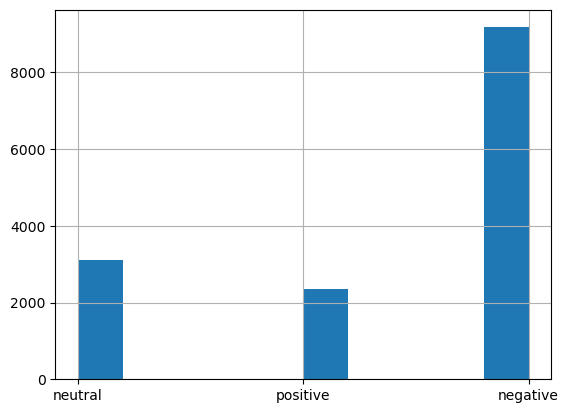

In [10]:
df['airline_sentiment'].hist()

In [11]:
df = df[df['airline_sentiment'] != 'neutral'].copy()

In [12]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [13]:
df_train, df_test = train_test_split(df, random_state=42)

In [14]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [15]:
# It must not be a spare matrix
X_train = X_train.toarray()
X_test = X_test.toarray()

In [24]:
Y_train = df_train['target']
Y_test = df_test['target']

In [16]:
# input dimensions
D = X_train.shape[1]

In [17]:
# Build model
i = Input(shape = (D,))
x = Dense(1)(i) #sigmoid included in loss

model = Model(i, x)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
    loss = BinaryCrossentropy(from_logits=True),
    optimizer = Adam(learning_rate = 0.01),
    metrics = ['accuracy']
)

In [25]:
r = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs = 40,
    batch_size = 128
)

Epoch 1/40
68/68 [==============================] - 2s 11ms/step - loss: 0.5022 - accuracy: 0.7920 - val_loss: 0.3974 - val_accuracy: 0.8049
Epoch 2/40
68/68 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.7960 - val_loss: 0.3400 - val_accuracy: 0.8202
Epoch 3/40
68/68 [==============================] - 0s 5ms/step - loss: 0.3228 - accuracy: 0.8185 - val_loss: 0.3034 - val_accuracy: 0.8420
Epoch 4/40
68/68 [==============================] - 0s 4ms/step - loss: 0.2853 - accuracy: 0.8433 - val_loss: 0.2775 - val_accuracy: 0.8611
Epoch 5/40
68/68 [==============================] - 0s 5ms/step - loss: 0.2579 - accuracy: 0.8639 - val_loss: 0.2585 - val_accuracy: 0.8742
Epoch 6/40
68/68 [==============================] - 0s 4ms/step - loss: 0.2370 - accuracy: 0.8802 - val_loss: 0.2444 - val_accuracy: 0.8870
Epoch 7/40
68/68 [==============================] - 0s 4ms/step - loss: 0.2206 - accuracy: 0.8930 - val_loss: 0.2338 - val_accuracy: 0.8964
Epoch 8/40
68/68 [=

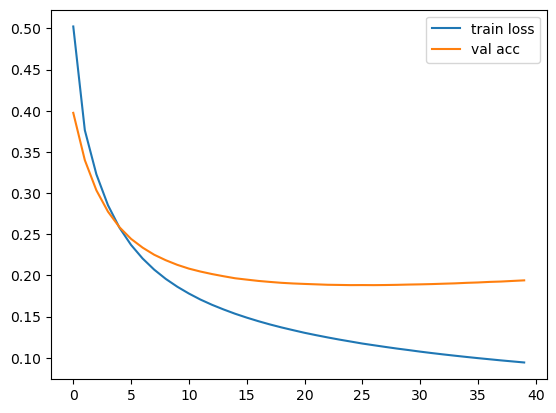

In [29]:
# plot loss per iteration
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val acc')
plt.legend();

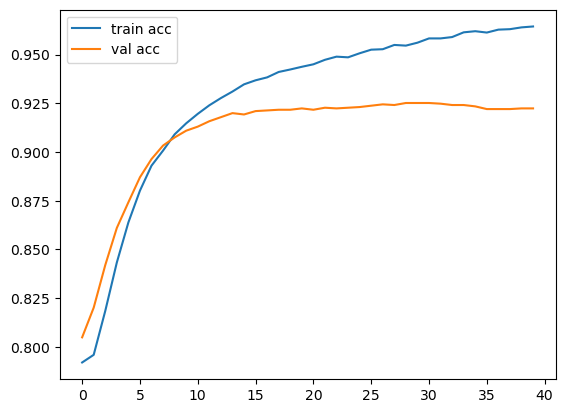

In [28]:
# plot loss accuracy iteration
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend();

In [30]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()


91/91 [==============================] - 0s 2ms/step


In [32]:
cm = confusion_matrix(Y_train, P_train, normalize = 'true')
cm

array([[0.99022611, 0.00977389],
       [0.09611111, 0.90388889]])

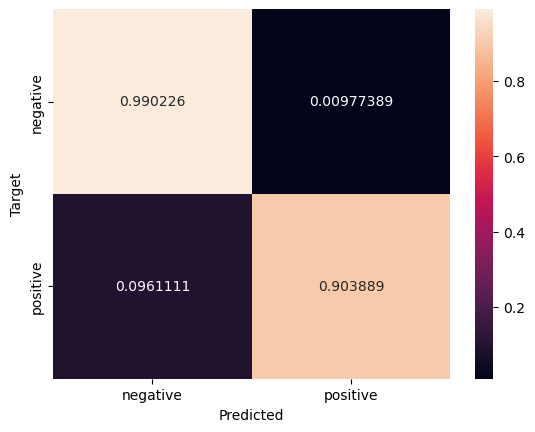

In [34]:
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index = classes, columns = classes)
    ax = sn.heatmap(df_cm, annot = True, fmt = 'g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")
    
plot_cm(cm)

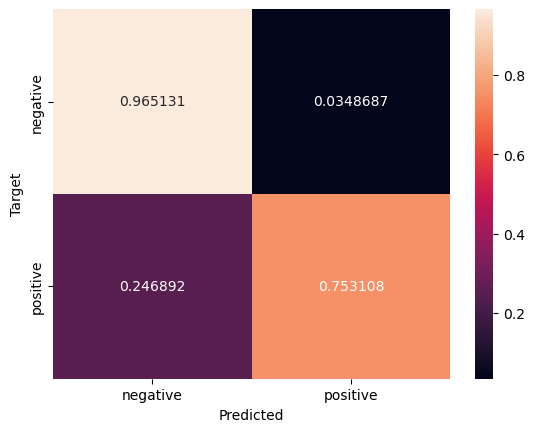

In [35]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

In [36]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)

print("Train AUC: ", roc_auc_score(Y_train, Pr_train))
print("Test AUC: ", roc_auc_score(Y_test, Pr_test))


91/91 [==============================] - 0s 2ms/step
Train AUC:  0.994972769268174
Test AUC:  0.9546537864845255


In [37]:
print("Train F1: ", f1_score(Y_train, P_train))
print("Test F1: ", f1_score(Y_test, P_test))

Train F1:  0.931310818546079
Test F1:  0.7940074906367043


In [38]:
model.layers

In [39]:
model.layers[1].get_weights()

[array([[-4.002048 ],
        [ 3.2601428],
        [-1.5626224],
        ...,
        [ 2.0046566],
        [ 1.6411362],
        [-2.9505992]], dtype=float32),
 array([-0.23147376], dtype=float32)]

In [40]:
w = model.layers[1].get_weights()[0]

In [41]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,


In [43]:
# Most positive words

threshold = 2

print("Most positive words: ")

word_weight_tuples = []
for word, index in word_index_map.items():
    weight  = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))
        

word_weight_tuples = sorted(word_weight_tuples, key = lambda x: -x[1])

for i in range(10):
    word, weight = word_weight_tuples[i]

    print(word, weight)

Most positive words: 
thank 9.671566
thanks 9.39621
worries 8.454507
great 7.92991
awesome 7.3768353
love 7.1654224
excellent 7.0675716
kudos 6.7612224
amazing 6.4141197
best 6.1224914


In [45]:
print("Most negative words: ")

word_weight_tuples = []
for word, index in word_index_map.items():
    weight  = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))
        

word_weight_tuples = sorted(word_weight_tuples, key = lambda x: x[1])

for i in range(10):
    word, weight = word_weight_tuples[i]

    print(word, weight)

Most negative words: 
worst -9.134157
not -7.6973667
rude -7.623676
paid -7.5124116
disappointed -7.253281
hung -6.7974453
nothing -6.7423587
website -6.626409
list -6.5344653
instead -6.450311
